# K-Fold CV for Boosting Methods Using SKLearn 

In [57]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import wfdb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd

In [58]:
import xgboost as xgb
from sklearn import metrics
from lightgbm import LGBMClassifier

import lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats

### To load sklearn dataset
sklearn.datasets.load_breast_cancer(*, return_X_y=False, as_frame=False)[source]¶

Load and return the breast cancer wisconsin dataset (classification).

In [60]:
#data = load_breast_cancer(as_frame = True); 
#df = data.frame; 
#print(df.shape)
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .
rlist = []
records = 'mit-bih-raw\RECORDS' # Replace the _______ with the name of the records file in your MIT-BIH data folder
with open(records) as rfile: #Then we open the file 
                             #The 'with' command only opens the file while we are in it. Automatically closes the file when we're not
    for record in rfile:  # Then we iterate through the lines in the file
        record = record[0:len(record)-1] # Remove any erronious new line characters at the end ('\n')
        rlist.append(record) # Then build an array with it
        

###### Step 1: Initialize all Arrays
             # Below, replace all of the ___ with the command that declares an array/list
             # hint: https://stackoverflow.com/questions/1514553/how-to-declare-an-array-in-python
samples = [] # will house the samples of all subjects
good_list = [] # will list the names of the subjects we successfully extracted
bad_list = [] # will house the names of the subjects we failed to extract
qrs = [] # will house the indices of R-Peaks for all subjects
atr_label = [] # will house the labels for each rhythm annotation for all subjects
atr_locs = [] # will house the locations corresponding to the rhythm annotation labels


###### Step 2: Extract Information
for x in tqdm(rlist): #this will iterate through te records that we found above
  
    try: # A try statement will run the except statement if for some reason the try commands fail
         # In this case I use the try statement because one of the subjects has no signal data causing failure
         # I then use bad_list and good_list so that all of the indices in rlist match with the arrays we initialized in Step 1, above
        ######################################################
            # Below find the wfdb function that will return the information that is described below 
        # Then replace _____ with the correct function call
        samp = wfdb.rdsamp('mit-bih-raw/'+x) # wfdb._____(file_location) will read the signal & header data and return a 2 value array
            # samp[0] - the signal data is the raw reading from the ecg. Each value is a sample taken.
            # samp[1] - the header data includes things about the signal data such as:
              # samples per section, denoted 'fs'
              # number of signals, denoted 'n_sig'
            
        ######################################################
        samples.append(samp) #add it to our array for all subject
            #What is our file extension that has the annotation we want? Find it here and replace _____ with it 
            #hint: READ THE VARIABLE NAMES!!!!
        qrs_tmp = wfdb.rdann('mit-bih-raw/'+x, extension='qrs') #extract the QRS Info
        qrs_locs = np.array(qrs_tmp.sample, dtype='int') #Get just the loccation of R-Peaks from the QRS Info
        qrs.append(qrs_locs) # Add to our array for all subjects
        
            #Do the same thing here
        atr = wfdb.rdann('mit-bih-raw/'+x,extension='atr') #extract the atr info which stores the rhythm type(s) over the whole signal
        atr_label.append(atr.aux_note) # aux_note stores the type of rhythm - main two are '(N' for normal and '(AFIB' for AFIB
        atr_locs.append(np.append(atr.sample, len(samp[0]))) #I add the length of the whole sample to the end for better visualization later
        
        good_list.append(x) # when all extraction is successful append the record name to good_list
    except Exception as exep:
        print(exep) # Alert the user of an exception
        bad_list.append(x) # add to the bad list

        

  0%|          | 0/25 [00:00<?, ?it/s]

sampto must be greater than sampfrom
sampto must be greater than sampfrom


100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


In [61]:
features_df_list = []
for subject in good_list:
    data = pd.read_csv(f'subject-features-dataframes/subject{subject}.csv')
    data = data.assign(Subject = subject)
    #print(data)
    features_df_list.append(data)

In [62]:
#df.head(5)
# df.info()
# df.describe()
#features_df_list[0]
counter = 0
testing_arr = []
training_arr = []
for subject in features_df_list:
    if counter != 22:
        training_arr.append(subject)
    else:
        testing_arr.append(subject)
    counter += 1
    
print(len(training_arr))
#type(df)

22


In [63]:
features_maindf = pd.concat(features_df_list, ignore_index = True)
print(features_maindf.columns)

Index(['Unnamed: 0', 'StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn', 'Rhythm', 'Subject'],
      dtype='object')


# Extreme Gradient Boosting

1.5.1


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


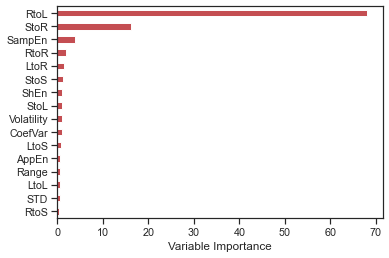

roc_auc_score 0.9700770143983442


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


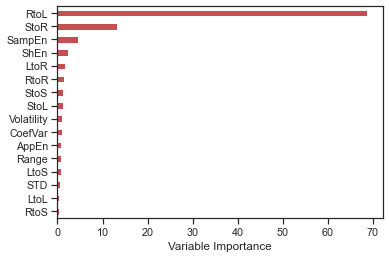

roc_auc_score 0.9835583160800552


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


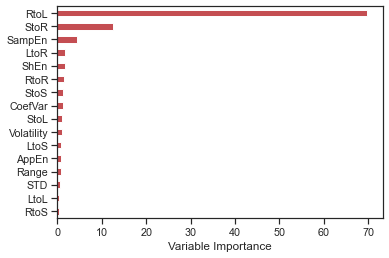

roc_auc_score 0.9992859253422633


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


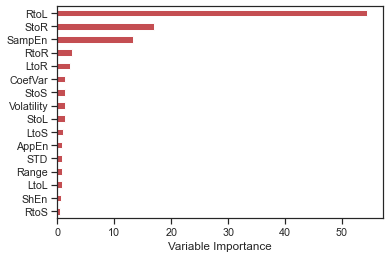

roc_auc_score 0.9894610432648454


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


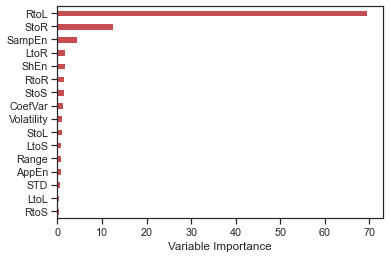

roc_auc_score 0.9999952299463966


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


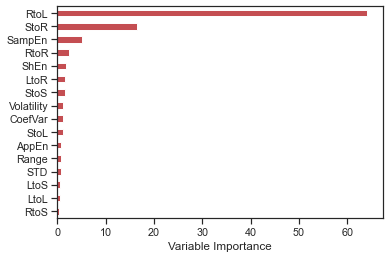

roc_auc_score 0.9903395018997954


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


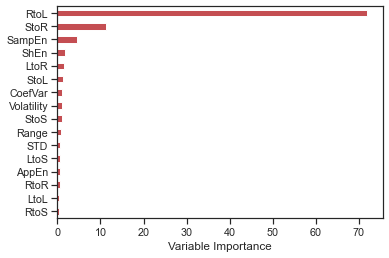

roc_auc_score 0.8871196253377581


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


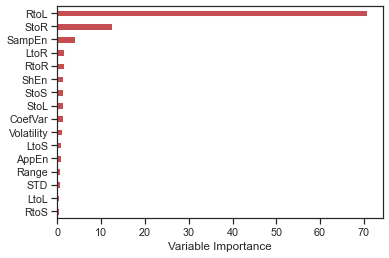

roc_auc_score 0.9991803278688525


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


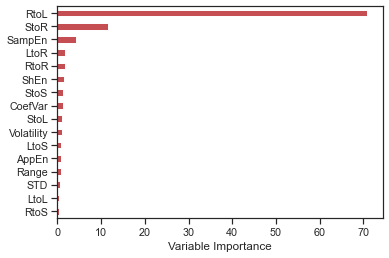

roc_auc_score 0.9692127285387492


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


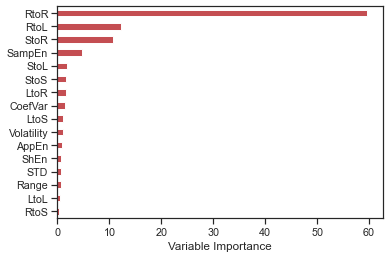

roc_auc_score 0.9914371321236825


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


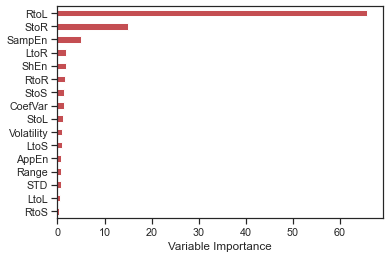

roc_auc_score 0.9314900806878004


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


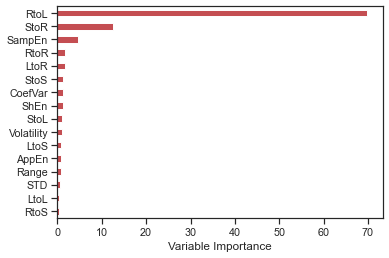

roc_auc_score 0.958874829001368


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


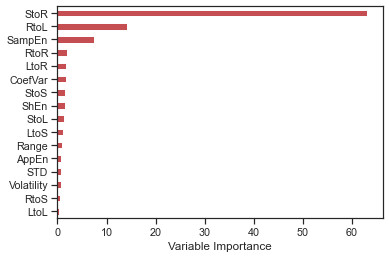

roc_auc_score 0.9501997554887509


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


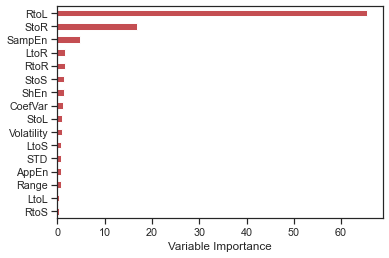

ROC_AUC not able to be calculated for subject 07162


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


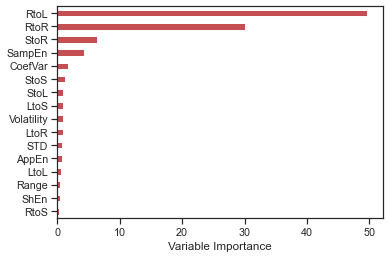

ROC_AUC not able to be calculated for subject 07859


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


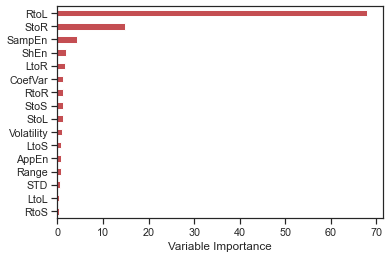

roc_auc_score 0.9992232323788651


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


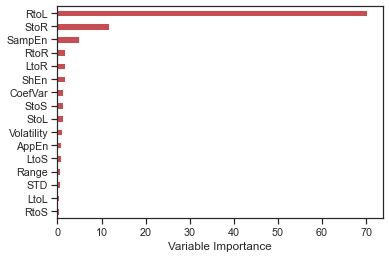

roc_auc_score 0.998193315266486


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


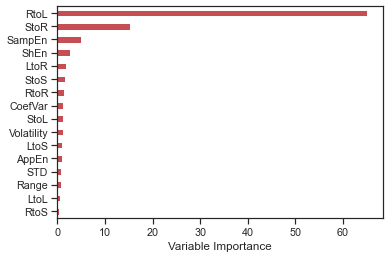

roc_auc_score 0.9984229459517355


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


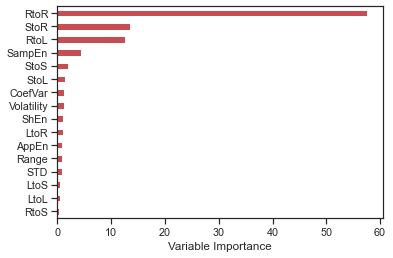

roc_auc_score 0.9504547141796585


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


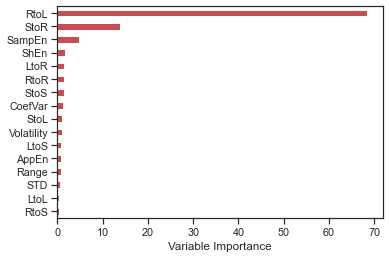

roc_auc_score 0.9806919287828108


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


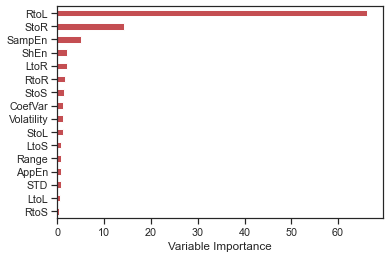

roc_auc_score 0.997703884482408


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


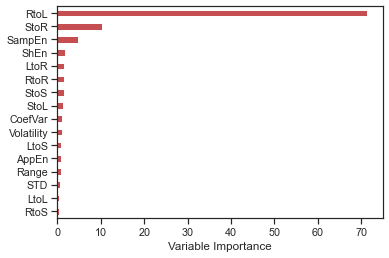

roc_auc_score 0.9998494623655914


C:\Users\Luke\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


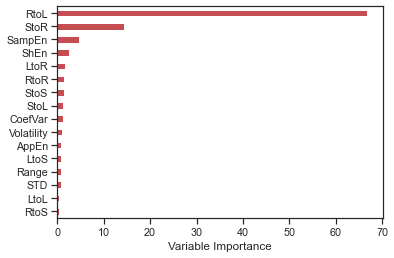

roc_auc_score 0.9999524117891861
---Run time is 79.37701260000176 seconds ---

Accuracy of each fold: 
 [0.9130434782608695, 0.9464503042596348, 0.9943324937027708, 0.9244604316546763, 0.9968652037617555, 0.9432048681541582, 0.814105558150397, 0.9979577944179714, 0.9246987951807228, 0.9592061742006616, 0.9782214156079855, 0.9913854989231874, 0.8453514739229024, 0.935031847133758, 0.46419650291423814, 0.9942401417811254, 0.9856065798492117, 0.9803808424697057, 0.698647506339814, 0.8949972512369434, 0.9927288280581694, 0.9968612680477087, 0.9970401691331924]

Avg accuracy : 
0.92039193161572

Std of accuracy : 
0.12047795012324398


In [64]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# check xgboost version
import xgboost
import xgboost as xgb
from xgboost import XGBClassifier
print(xgboost.__version__)
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics

#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)#, random_state=1)
# Create the Extreme GBM
model = XGBClassifier(n_estimators=100, learning_rate = 0.1,use_label_encoder =False,verbose=None,
                max_depth = 5, eval_metric='logloss')
    
from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values], df.loc[test_index,y_values]

    
    model.fit(X_train,y_train)

    pred_values = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list 
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    plt.show()
    #plt.savefig('plot1.png')
    
    ##################################################
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
    #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
    try:
        print("roc_auc_score", roc_auc_score(y_test, pred_prob))
    except:
        print(f'ROC_AUC not able to be calculated for subject {subject}')
    # calculate the fpr and tpr for all thresholds of the classification
    #fpr, tpr, threshold = metrics.roc_curve(y_test, pred_prob)
    #roc_auc = metrics.auc(fpr, tpr)
    # method I: plt
    #import matplotlib.pyplot as plt
    #plt.title('Receiver Operating Characteristic')
    #plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    #plt.legend(loc = 'lower right')
    #plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([-0.05, 1])
    #plt.ylim([0, 1.05])
    #plt.ylabel('True Positive Rate')
    #plt.xlabel('False Positive Rate')
    #plt.show()
    ##################################################
    
elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

# Reference: 

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

max_depth (int, optional (default=-1)) – Maximum tree depth for base learners, <=0 means no limit.

learning_rate (float, optional (default=0.1)) – Boosting learning rate. You can use callbacks parameter of fit method to shrink/adapt learning rate in training using reset_parameter callback. Note, that this will ignore the learning_rate argument in training.

n_estimators (int, optional (default=100)) – Number of boosted trees to fit.

eval_metric (str, callable, list or None, optional (default=None)) – If str, it should be a built-in evaluation metric to use. If callable, it should be a custom evaluation metric, see note below for more details. If list, it can be a list of built-in metrics, a list of custom evaluation metrics, or a mix of both. In either case, the metric from the model parameters will be evaluated and used as well. 
Default: ‘l2’ for LGBMRegressor, **‘logloss’ for LGBMClassifier**, ‘ndcg’ for LGBMRanker.


C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61949	valid_0's binary_logloss: 0.571645
[2]	training's binary_logloss: 0.559604	valid_0's binary_logloss: 0.521574
[3]	training's binary_logloss: 0.50895	valid_0's binary_logloss: 0.479925
[4]	training's binary_logloss: 0.465259	valid_0's binary_logloss: 0.44428
[5]	training's binary_logloss: 0.42757	valid_0's binary_logloss: 0.41423
[6]	training's binary_logloss: 0.394716	valid_0's binary_logloss: 0.388343
[7]	training's binary_logloss: 0.365656	valid_0's binary_logloss: 0.36684
[8]	training's binary_logloss: 0.340058	valid_0's binary_logloss: 0.347705
[9]	training's binary_logloss: 0.317416	valid_0's binary_logloss: 0.331559
[10]	training's binary_logloss: 0.297386	valid_0's binary_logloss: 0.31824
[11]	training's binary_logloss: 0.279496	valid_0's binary_logloss: 0.306259
[12]	training's binary_logloss: 0.263266	valid_0's binary_logloss: 0.296419
[13]	training's binary_logloss: 0.248831	valid_0's binary_logloss: 0.287931
[14]	training's binary_loglo

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618941	valid_0's binary_logloss: 0.588766
[2]	training's binary_logloss: 0.559395	valid_0's binary_logloss: 0.532146
[3]	training's binary_logloss: 0.509103	valid_0's binary_logloss: 0.484371
[4]	training's binary_logloss: 0.465979	valid_0's binary_logloss: 0.443558
[5]	training's binary_logloss: 0.428474	valid_0's binary_logloss: 0.407935
[6]	training's binary_logloss: 0.395875	valid_0's binary_logloss: 0.377915
[7]	training's binary_logloss: 0.366973	valid_0's binary_logloss: 0.351286
[8]	training's binary_logloss: 0.341835	valid_0's binary_logloss: 0.32755
[9]	training's binary_logloss: 0.319497	valid_0's binary_logloss: 0.307371
[10]	training's binary_logloss: 0.299551	valid_0's binary_logloss: 0.288495
[11]	training's binary_logloss: 0.281498	valid_0's binary_logloss: 0.271822
[12]	training's binary_logloss: 0.265629	valid_0's binary_logloss: 0.257298
[13]	training's binary_logloss: 0.251628	valid_0's binary_logloss: 0.244466
[14]	training's binary

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.620048	valid_0's binary_logloss: 0.555703
[2]	training's binary_logloss: 0.560955	valid_0's binary_logloss: 0.493857
[3]	training's binary_logloss: 0.510876	valid_0's binary_logloss: 0.440877
[4]	training's binary_logloss: 0.467893	valid_0's binary_logloss: 0.394845
[5]	training's binary_logloss: 0.430889	valid_0's binary_logloss: 0.355293
[6]	training's binary_logloss: 0.39858	valid_0's binary_logloss: 0.320249
[7]	training's binary_logloss: 0.36987	valid_0's binary_logloss: 0.289272
[8]	training's binary_logloss: 0.34466	valid_0's binary_logloss: 0.261852
[9]	training's binary_logloss: 0.322478	valid_0's binary_logloss: 0.237503
[10]	training's binary_logloss: 0.30258	valid_0's binary_logloss: 0.215737
[11]	training's binary_logloss: 0.284955	valid_0's binary_logloss: 0.196251
[12]	training's binary_logloss: 0.269071	valid_0's binary_logloss: 0.178992
[13]	training's binary_logloss: 0.255019	valid_0's binary_logloss: 0.163224
[14]	training's binary_lo

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.619234	valid_0's binary_logloss: 0.57736
[2]	training's binary_logloss: 0.559595	valid_0's binary_logloss: 0.530873
[3]	training's binary_logloss: 0.508922	valid_0's binary_logloss: 0.492485
[4]	training's binary_logloss: 0.465201	valid_0's binary_logloss: 0.458509
[5]	training's binary_logloss: 0.427544	valid_0's binary_logloss: 0.429162
[6]	training's binary_logloss: 0.394749	valid_0's binary_logloss: 0.403675
[7]	training's binary_logloss: 0.365895	valid_0's binary_logloss: 0.381717
[8]	training's binary_logloss: 0.340464	valid_0's binary_logloss: 0.363456
[9]	training's binary_logloss: 0.317899	valid_0's binary_logloss: 0.346291
[10]	training's binary_logloss: 0.297673	valid_0's binary_logloss: 0.333945
[11]	training's binary_logloss: 0.280022	valid_0's binary_logloss: 0.319234
[12]	training's binary_logloss: 0.263977	valid_0's binary_logloss: 0.309911
[13]	training's binary_logloss: 0.249622	valid_0's binary_logloss: 0.298373
[14]	training's binary

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61562	valid_0's binary_logloss: 0.64784
[2]	training's binary_logloss: 0.556779	valid_0's binary_logloss: 0.576163
[3]	training's binary_logloss: 0.506994	valid_0's binary_logloss: 0.515308
[4]	training's binary_logloss: 0.464341	valid_0's binary_logloss: 0.463343
[5]	training's binary_logloss: 0.427466	valid_0's binary_logloss: 0.418444
[6]	training's binary_logloss: 0.395337	valid_0's binary_logloss: 0.379297
[7]	training's binary_logloss: 0.367013	valid_0's binary_logloss: 0.34494
[8]	training's binary_logloss: 0.342333	valid_0's binary_logloss: 0.31458
[9]	training's binary_logloss: 0.320173	valid_0's binary_logloss: 0.287486
[10]	training's binary_logloss: 0.300945	valid_0's binary_logloss: 0.263498
[11]	training's binary_logloss: 0.283418	valid_0's binary_logloss: 0.242072
[12]	training's binary_logloss: 0.267872	valid_0's binary_logloss: 0.222859
[13]	training's binary_logloss: 0.253487	valid_0's binary_logloss: 0.205789
[14]	training's binary_lo

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.62041	valid_0's binary_logloss: 0.583782
[2]	training's binary_logloss: 0.560889	valid_0's binary_logloss: 0.534904
[3]	training's binary_logloss: 0.510325	valid_0's binary_logloss: 0.49093
[4]	training's binary_logloss: 0.466874	valid_0's binary_logloss: 0.450559
[5]	training's binary_logloss: 0.429397	valid_0's binary_logloss: 0.415282
[6]	training's binary_logloss: 0.396732	valid_0's binary_logloss: 0.386039
[7]	training's binary_logloss: 0.367908	valid_0's binary_logloss: 0.364164
[8]	training's binary_logloss: 0.342573	valid_0's binary_logloss: 0.345225
[9]	training's binary_logloss: 0.320122	valid_0's binary_logloss: 0.32393
[10]	training's binary_logloss: 0.30018	valid_0's binary_logloss: 0.309862
[11]	training's binary_logloss: 0.282439	valid_0's binary_logloss: 0.297609
[12]	training's binary_logloss: 0.266171	valid_0's binary_logloss: 0.281604
[13]	training's binary_logloss: 0.25201	valid_0's binary_logloss: 0.272778
[14]	training's binary_log

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.612728	valid_0's binary_logloss: 0.701295
[2]	training's binary_logloss: 0.552885	valid_0's binary_logloss: 0.648573
[3]	training's binary_logloss: 0.502401	valid_0's binary_logloss: 0.604613
[4]	training's binary_logloss: 0.458899	valid_0's binary_logloss: 0.571835
[5]	training's binary_logloss: 0.420934	valid_0's binary_logloss: 0.541597
[6]	training's binary_logloss: 0.388278	valid_0's binary_logloss: 0.515194
[7]	training's binary_logloss: 0.359172	valid_0's binary_logloss: 0.496106
[8]	training's binary_logloss: 0.333768	valid_0's binary_logloss: 0.476869
[9]	training's binary_logloss: 0.311295	valid_0's binary_logloss: 0.459929
[10]	training's binary_logloss: 0.291252	valid_0's binary_logloss: 0.445686
[11]	training's binary_logloss: 0.273477	valid_0's binary_logloss: 0.430864
[12]	training's binary_logloss: 0.257611	valid_0's binary_logloss: 0.42226
[13]	training's binary_logloss: 0.243356	valid_0's binary_logloss: 0.414077
[14]	training's binary

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.619924	valid_0's binary_logloss: 0.552794
[2]	training's binary_logloss: 0.560814	valid_0's binary_logloss: 0.491135
[3]	training's binary_logloss: 0.510727	valid_0's binary_logloss: 0.438199
[4]	training's binary_logloss: 0.467808	valid_0's binary_logloss: 0.392432
[5]	training's binary_logloss: 0.430837	valid_0's binary_logloss: 0.352816
[6]	training's binary_logloss: 0.398538	valid_0's binary_logloss: 0.317889
[7]	training's binary_logloss: 0.370008	valid_0's binary_logloss: 0.287195
[8]	training's binary_logloss: 0.344725	valid_0's binary_logloss: 0.259944
[9]	training's binary_logloss: 0.322617	valid_0's binary_logloss: 0.235672
[10]	training's binary_logloss: 0.302959	valid_0's binary_logloss: 0.214378
[11]	training's binary_logloss: 0.285236	valid_0's binary_logloss: 0.194868
[12]	training's binary_logloss: 0.269285	valid_0's binary_logloss: 0.177873
[13]	training's binary_logloss: 0.255179	valid_0's binary_logloss: 0.162322
[14]	training's binar

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.614313	valid_0's binary_logloss: 0.669966
[2]	training's binary_logloss: 0.554919	valid_0's binary_logloss: 0.607796
[3]	training's binary_logloss: 0.50479	valid_0's binary_logloss: 0.556269
[4]	training's binary_logloss: 0.461486	valid_0's binary_logloss: 0.512942
[5]	training's binary_logloss: 0.423964	valid_0's binary_logloss: 0.475355
[6]	training's binary_logloss: 0.391618	valid_0's binary_logloss: 0.443024
[7]	training's binary_logloss: 0.362794	valid_0's binary_logloss: 0.415738
[8]	training's binary_logloss: 0.337791	valid_0's binary_logloss: 0.391637
[9]	training's binary_logloss: 0.315402	valid_0's binary_logloss: 0.369895
[10]	training's binary_logloss: 0.295546	valid_0's binary_logloss: 0.35216
[11]	training's binary_logloss: 0.277602	valid_0's binary_logloss: 0.33577
[12]	training's binary_logloss: 0.261817	valid_0's binary_logloss: 0.320716
[13]	training's binary_logloss: 0.247643	valid_0's binary_logloss: 0.308687
[14]	training's binary_l

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.620474	valid_0's binary_logloss: 0.570333
[2]	training's binary_logloss: 0.561389	valid_0's binary_logloss: 0.517645
[3]	training's binary_logloss: 0.511387	valid_0's binary_logloss: 0.472393
[4]	training's binary_logloss: 0.468096	valid_0's binary_logloss: 0.434476
[5]	training's binary_logloss: 0.43083	valid_0's binary_logloss: 0.401765
[6]	training's binary_logloss: 0.398248	valid_0's binary_logloss: 0.372378
[7]	training's binary_logloss: 0.369706	valid_0's binary_logloss: 0.347158
[8]	training's binary_logloss: 0.344409	valid_0's binary_logloss: 0.324638
[9]	training's binary_logloss: 0.322266	valid_0's binary_logloss: 0.304272
[10]	training's binary_logloss: 0.302556	valid_0's binary_logloss: 0.286434
[11]	training's binary_logloss: 0.284849	valid_0's binary_logloss: 0.270521
[12]	training's binary_logloss: 0.268966	valid_0's binary_logloss: 0.257522
[13]	training's binary_logloss: 0.254262	valid_0's binary_logloss: 0.245091
[14]	training's binary

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.610806	valid_0's binary_logloss: 0.746541
[2]	training's binary_logloss: 0.552149	valid_0's binary_logloss: 0.662667
[3]	training's binary_logloss: 0.502477	valid_0's binary_logloss: 0.592607
[4]	training's binary_logloss: 0.460008	valid_0's binary_logloss: 0.53363
[5]	training's binary_logloss: 0.423457	valid_0's binary_logloss: 0.483843
[6]	training's binary_logloss: 0.391392	valid_0's binary_logloss: 0.44045
[7]	training's binary_logloss: 0.363669	valid_0's binary_logloss: 0.402452
[8]	training's binary_logloss: 0.339139	valid_0's binary_logloss: 0.369146
[9]	training's binary_logloss: 0.317143	valid_0's binary_logloss: 0.339966
[10]	training's binary_logloss: 0.297791	valid_0's binary_logloss: 0.31388
[11]	training's binary_logloss: 0.280344	valid_0's binary_logloss: 0.290764
[12]	training's binary_logloss: 0.264864	valid_0's binary_logloss: 0.270433
[13]	training's binary_logloss: 0.250734	valid_0's binary_logloss: 0.251977
[14]	training's binary_l

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.619646	valid_0's binary_logloss: 0.554081
[2]	training's binary_logloss: 0.560522	valid_0's binary_logloss: 0.49464
[3]	training's binary_logloss: 0.510415	valid_0's binary_logloss: 0.443302
[4]	training's binary_logloss: 0.467325	valid_0's binary_logloss: 0.399008
[5]	training's binary_logloss: 0.430089	valid_0's binary_logloss: 0.360723
[6]	training's binary_logloss: 0.397726	valid_0's binary_logloss: 0.327125
[7]	training's binary_logloss: 0.369267	valid_0's binary_logloss: 0.297802
[8]	training's binary_logloss: 0.344319	valid_0's binary_logloss: 0.271885
[9]	training's binary_logloss: 0.322344	valid_0's binary_logloss: 0.248763
[10]	training's binary_logloss: 0.302582	valid_0's binary_logloss: 0.227892
[11]	training's binary_logloss: 0.284804	valid_0's binary_logloss: 0.209025
[12]	training's binary_logloss: 0.268558	valid_0's binary_logloss: 0.192119
[13]	training's binary_logloss: 0.254461	valid_0's binary_logloss: 0.177003
[14]	training's binary

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.616028	valid_0's binary_logloss: 0.645662
[2]	training's binary_logloss: 0.55639	valid_0's binary_logloss: 0.601359
[3]	training's binary_logloss: 0.505613	valid_0's binary_logloss: 0.564298
[4]	training's binary_logloss: 0.462265	valid_0's binary_logloss: 0.542169
[5]	training's binary_logloss: 0.424459	valid_0's binary_logloss: 0.514279
[6]	training's binary_logloss: 0.391867	valid_0's binary_logloss: 0.499634
[7]	training's binary_logloss: 0.36313	valid_0's binary_logloss: 0.485483
[8]	training's binary_logloss: 0.337488	valid_0's binary_logloss: 0.46502
[9]	training's binary_logloss: 0.315078	valid_0's binary_logloss: 0.45668
[10]	training's binary_logloss: 0.294575	valid_0's binary_logloss: 0.442201
[11]	training's binary_logloss: 0.276267	valid_0's binary_logloss: 0.430118
[12]	training's binary_logloss: 0.260378	valid_0's binary_logloss: 0.421766
[13]	training's binary_logloss: 0.245756	valid_0's binary_logloss: 0.416433
[14]	training's binary_lo

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.612833	valid_0's binary_logloss: 0.757759
[2]	training's binary_logloss: 0.55378	valid_0's binary_logloss: 0.684473
[3]	training's binary_logloss: 0.503946	valid_0's binary_logloss: 0.625214
[4]	training's binary_logloss: 0.461149	valid_0's binary_logloss: 0.576542
[5]	training's binary_logloss: 0.424249	valid_0's binary_logloss: 0.531864
[6]	training's binary_logloss: 0.392451	valid_0's binary_logloss: 0.493609
[7]	training's binary_logloss: 0.364227	valid_0's binary_logloss: 0.459258
[8]	training's binary_logloss: 0.339176	valid_0's binary_logloss: 0.430421
[9]	training's binary_logloss: 0.317352	valid_0's binary_logloss: 0.402492
[10]	training's binary_logloss: 0.297834	valid_0's binary_logloss: 0.380255
[11]	training's binary_logloss: 0.280158	valid_0's binary_logloss: 0.358468
[12]	training's binary_logloss: 0.264272	valid_0's binary_logloss: 0.339403
[13]	training's binary_logloss: 0.250405	valid_0's binary_logloss: 0.322244
[14]	training's binary

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.606212	valid_0's binary_logloss: 0.867373
[2]	training's binary_logloss: 0.544988	valid_0's binary_logloss: 0.874525
[3]	training's binary_logloss: 0.493323	valid_0's binary_logloss: 0.881266
[4]	training's binary_logloss: 0.449352	valid_0's binary_logloss: 0.888036
[5]	training's binary_logloss: 0.411482	valid_0's binary_logloss: 0.898763
[6]	training's binary_logloss: 0.37854	valid_0's binary_logloss: 0.910623
[7]	training's binary_logloss: 0.349605	valid_0's binary_logloss: 0.923739
[8]	training's binary_logloss: 0.324044	valid_0's binary_logloss: 0.936479
[9]	training's binary_logloss: 0.301549	valid_0's binary_logloss: 0.955061
[10]	training's binary_logloss: 0.281765	valid_0's binary_logloss: 0.969248
[11]	training's binary_logloss: 0.264136	valid_0's binary_logloss: 0.974804
[12]	training's binary_logloss: 0.248397	valid_0's binary_logloss: 0.985588
[13]	training's binary_logloss: 0.234371	valid_0's binary_logloss: 0.994707
[14]	training's binary

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.614359	valid_0's binary_logloss: 0.669434
[2]	training's binary_logloss: 0.555554	valid_0's binary_logloss: 0.598668
[3]	training's binary_logloss: 0.505719	valid_0's binary_logloss: 0.539161
[4]	training's binary_logloss: 0.463044	valid_0's binary_logloss: 0.487781
[5]	training's binary_logloss: 0.426221	valid_0's binary_logloss: 0.443982
[6]	training's binary_logloss: 0.394075	valid_0's binary_logloss: 0.404975
[7]	training's binary_logloss: 0.366136	valid_0's binary_logloss: 0.371619
[8]	training's binary_logloss: 0.341155	valid_0's binary_logloss: 0.342119
[9]	training's binary_logloss: 0.319217	valid_0's binary_logloss: 0.316126
[10]	training's binary_logloss: 0.299793	valid_0's binary_logloss: 0.292557
[11]	training's binary_logloss: 0.282218	valid_0's binary_logloss: 0.271412
[12]	training's binary_logloss: 0.266379	valid_0's binary_logloss: 0.252136
[13]	training's binary_logloss: 0.252558	valid_0's binary_logloss: 0.234602
[14]	training's binar

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618731	valid_0's binary_logloss: 0.572227
[2]	training's binary_logloss: 0.559538	valid_0's binary_logloss: 0.51133
[3]	training's binary_logloss: 0.509348	valid_0's binary_logloss: 0.459579
[4]	training's binary_logloss: 0.466357	valid_0's binary_logloss: 0.414993
[5]	training's binary_logloss: 0.42901	valid_0's binary_logloss: 0.376304
[6]	training's binary_logloss: 0.39672	valid_0's binary_logloss: 0.342569
[7]	training's binary_logloss: 0.368405	valid_0's binary_logloss: 0.313282
[8]	training's binary_logloss: 0.343561	valid_0's binary_logloss: 0.287614
[9]	training's binary_logloss: 0.321657	valid_0's binary_logloss: 0.26482
[10]	training's binary_logloss: 0.301791	valid_0's binary_logloss: 0.243901
[11]	training's binary_logloss: 0.284109	valid_0's binary_logloss: 0.225
[12]	training's binary_logloss: 0.267864	valid_0's binary_logloss: 0.208435
[13]	training's binary_logloss: 0.253803	valid_0's binary_logloss: 0.193543
[14]	training's binary_loglo

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.614453	valid_0's binary_logloss: 0.683806
[2]	training's binary_logloss: 0.55555	valid_0's binary_logloss: 0.613135
[3]	training's binary_logloss: 0.505753	valid_0's binary_logloss: 0.551843
[4]	training's binary_logloss: 0.463098	valid_0's binary_logloss: 0.50297
[5]	training's binary_logloss: 0.426217	valid_0's binary_logloss: 0.457724
[6]	training's binary_logloss: 0.393948	valid_0's binary_logloss: 0.419092
[7]	training's binary_logloss: 0.365945	valid_0's binary_logloss: 0.386683
[8]	training's binary_logloss: 0.340844	valid_0's binary_logloss: 0.358113
[9]	training's binary_logloss: 0.318655	valid_0's binary_logloss: 0.33174
[10]	training's binary_logloss: 0.299116	valid_0's binary_logloss: 0.308268
[11]	training's binary_logloss: 0.281771	valid_0's binary_logloss: 0.287992
[12]	training's binary_logloss: 0.265848	valid_0's binary_logloss: 0.268942
[13]	training's binary_logloss: 0.251872	valid_0's binary_logloss: 0.252164
[14]	training's binary_l

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617057	valid_0's binary_logloss: 0.631735
[2]	training's binary_logloss: 0.555722	valid_0's binary_logloss: 0.612454
[3]	training's binary_logloss: 0.503763	valid_0's binary_logloss: 0.600229
[4]	training's binary_logloss: 0.458925	valid_0's binary_logloss: 0.590303
[5]	training's binary_logloss: 0.420003	valid_0's binary_logloss: 0.58469
[6]	training's binary_logloss: 0.386291	valid_0's binary_logloss: 0.58207
[7]	training's binary_logloss: 0.356656	valid_0's binary_logloss: 0.579607
[8]	training's binary_logloss: 0.330653	valid_0's binary_logloss: 0.578762
[9]	training's binary_logloss: 0.307538	valid_0's binary_logloss: 0.577081
[10]	training's binary_logloss: 0.286904	valid_0's binary_logloss: 0.578244
[11]	training's binary_logloss: 0.268574	valid_0's binary_logloss: 0.579763
[12]	training's binary_logloss: 0.25225	valid_0's binary_logloss: 0.582399
[13]	training's binary_logloss: 0.237472	valid_0's binary_logloss: 0.58498
[14]	training's binary_lo

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618611	valid_0's binary_logloss: 0.593088
[2]	training's binary_logloss: 0.559279	valid_0's binary_logloss: 0.5411
[3]	training's binary_logloss: 0.509015	valid_0's binary_logloss: 0.494933
[4]	training's binary_logloss: 0.465986	valid_0's binary_logloss: 0.455411
[5]	training's binary_logloss: 0.428687	valid_0's binary_logloss: 0.424536
[6]	training's binary_logloss: 0.396109	valid_0's binary_logloss: 0.394498
[7]	training's binary_logloss: 0.367744	valid_0's binary_logloss: 0.367212
[8]	training's binary_logloss: 0.342725	valid_0's binary_logloss: 0.344114
[9]	training's binary_logloss: 0.320374	valid_0's binary_logloss: 0.324279
[10]	training's binary_logloss: 0.30063	valid_0's binary_logloss: 0.306088
[11]	training's binary_logloss: 0.282804	valid_0's binary_logloss: 0.287579
[12]	training's binary_logloss: 0.267001	valid_0's binary_logloss: 0.276038
[13]	training's binary_logloss: 0.252717	valid_0's binary_logloss: 0.264354
[14]	training's binary_l

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613472	valid_0's binary_logloss: 0.683883
[2]	training's binary_logloss: 0.554913	valid_0's binary_logloss: 0.608366
[3]	training's binary_logloss: 0.505158	valid_0's binary_logloss: 0.545494
[4]	training's binary_logloss: 0.462686	valid_0's binary_logloss: 0.491756
[5]	training's binary_logloss: 0.425954	valid_0's binary_logloss: 0.446954
[6]	training's binary_logloss: 0.393959	valid_0's binary_logloss: 0.407596
[7]	training's binary_logloss: 0.366072	valid_0's binary_logloss: 0.371938
[8]	training's binary_logloss: 0.34145	valid_0's binary_logloss: 0.340549
[9]	training's binary_logloss: 0.319515	valid_0's binary_logloss: 0.313202
[10]	training's binary_logloss: 0.299968	valid_0's binary_logloss: 0.289094
[11]	training's binary_logloss: 0.282659	valid_0's binary_logloss: 0.267629
[12]	training's binary_logloss: 0.26687	valid_0's binary_logloss: 0.248113
[13]	training's binary_logloss: 0.253111	valid_0's binary_logloss: 0.230059
[14]	training's binary_

C:\Users\Luke\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.619816	valid_0's binary_logloss: 0.559562
[2]	training's binary_logloss: 0.560825	valid_0's binary_logloss: 0.498031
[3]	training's binary_logloss: 0.510707	valid_0's binary_logloss: 0.445502
[4]	training's binary_logloss: 0.467845	valid_0's binary_logloss: 0.400883
[5]	training's binary_logloss: 0.431003	valid_0's binary_logloss: 0.362346
[6]	training's binary_logloss: 0.398858	valid_0's binary_logloss: 0.327863
[7]	training's binary_logloss: 0.370491	valid_0's binary_logloss: 0.297141
[8]	training's binary_logloss: 0.345566	valid_0's binary_logloss: 0.269986
[9]	training's binary_logloss: 0.323617	valid_0's binary_logloss: 0.246223
[10]	training's binary_logloss: 0.303395	valid_0's binary_logloss: 0.225186
[11]	training's binary_logloss: 0.285556	valid_0's binary_logloss: 0.205359
[12]	training's binary_logloss: 0.269474	valid_0's binary_logloss: 0.188025
[13]	training's binary_logloss: 0.255374	valid_0's binary_logloss: 0.172238
[14]	training's binar

C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Luke\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613747	valid_0's binary_logloss: 0.676628
[2]	training's binary_logloss: 0.555079	valid_0's binary_logloss: 0.601546
[3]	training's binary_logloss: 0.505546	valid_0's binary_logloss: 0.538793
[4]	training's binary_logloss: 0.463023	valid_0's binary_logloss: 0.484932
[5]	training's binary_logloss: 0.426251	valid_0's binary_logloss: 0.438822
[6]	training's binary_logloss: 0.394238	valid_0's binary_logloss: 0.398763
[7]	training's binary_logloss: 0.366422	valid_0's binary_logloss: 0.363448
[8]	training's binary_logloss: 0.341457	valid_0's binary_logloss: 0.332156
[9]	training's binary_logloss: 0.319584	valid_0's binary_logloss: 0.304673
[10]	training's binary_logloss: 0.299949	valid_0's binary_logloss: 0.279993
[11]	training's binary_logloss: 0.282722	valid_0's binary_logloss: 0.257983
[12]	training's binary_logloss: 0.266853	valid_0's binary_logloss: 0.238147
[13]	training's binary_logloss: 0.252944	valid_0's binary_logloss: 0.220334
[14]	training's binar

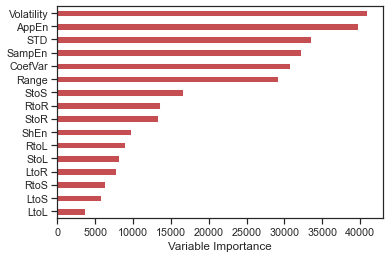

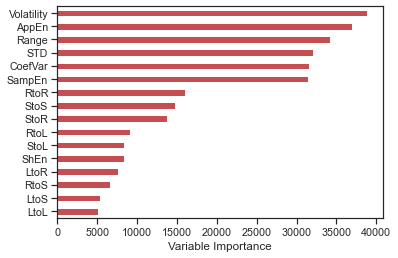

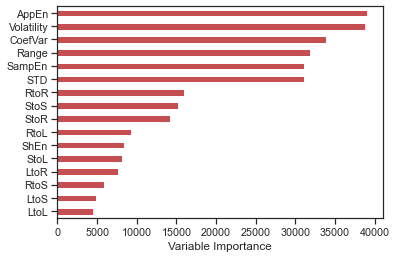

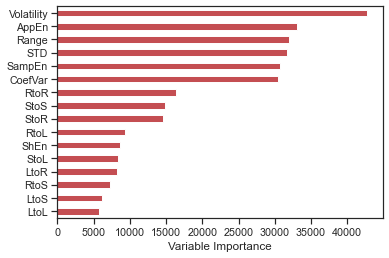

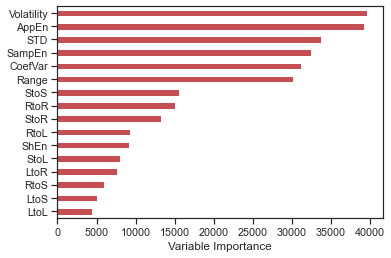

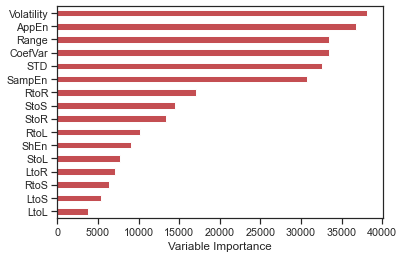

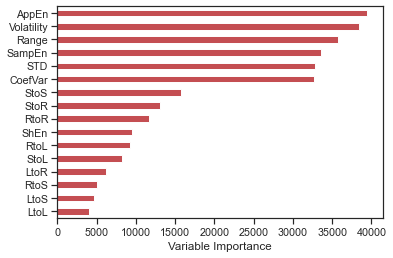

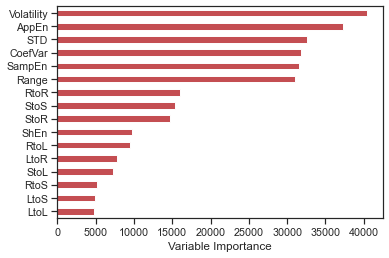

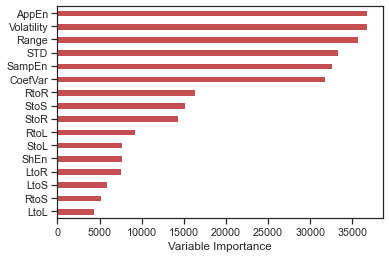

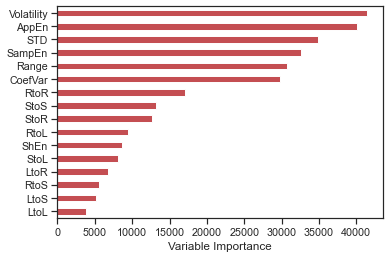

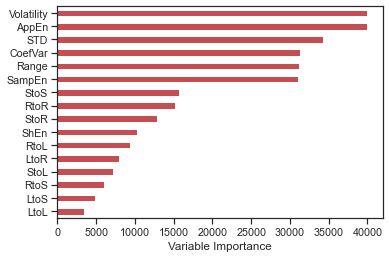

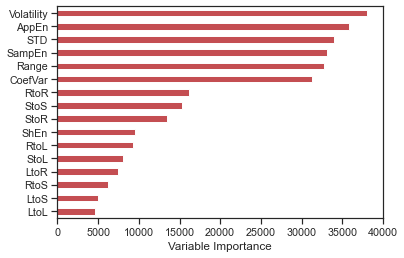

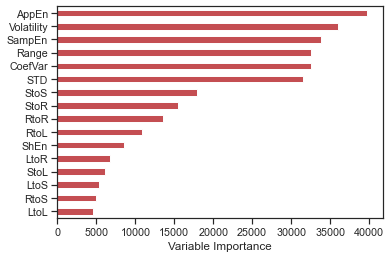

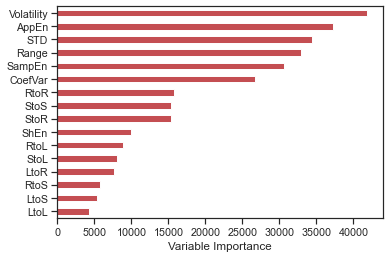

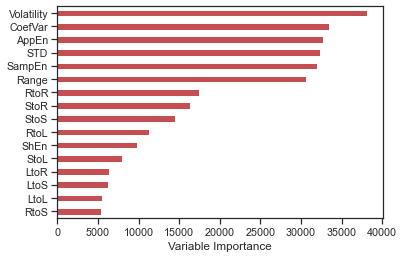

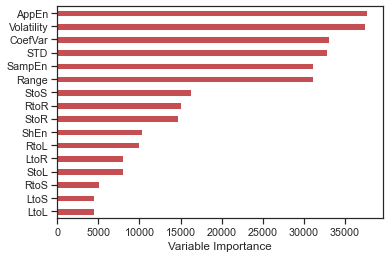

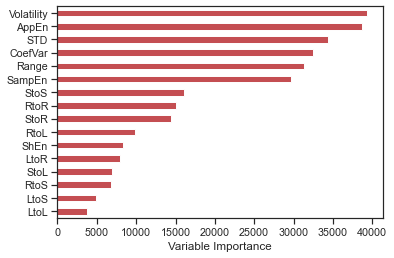

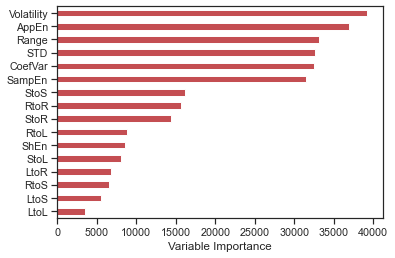

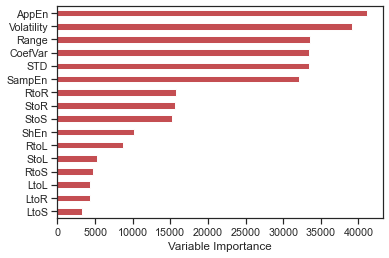

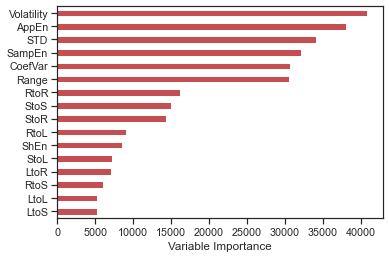

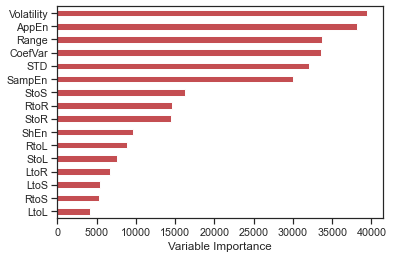

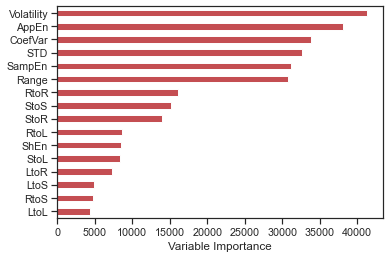

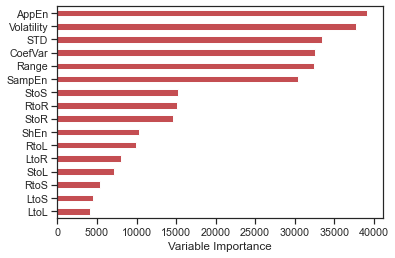

In [69]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import lightgbm

#Implementing cross validation 
kf = KFold(n_splits=23, random_state=1, shuffle=True)
model = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];

x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']


for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values], df.loc[test_index,y_values]

    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [9]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))

[[198  14]
 [  9 348]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       212
           1       0.96      0.97      0.97       357

    accuracy                           0.96       569
   macro avg       0.96      0.95      0.96       569
weighted avg       0.96      0.96      0.96       569



# CatBoosting

In [66]:
# https://catboost.ai/en/docs/concepts/python-quickstart
import catboost as cb
from catboost import CatBoostClassifier


print ('catboost version', cb.__version__)

catboost version 1.0.6


C:\Users\Luke\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


---Run time is 13.355848600000172 seconds ---

Accuracy of each fold: 
 [0.9096109839816934, 0.9460446247464503, 0.9955919395465995, 0.9268585131894485, 0.9952978056426333, 0.9334685598377281, 0.8407286314806165, 0.9979577944179714, 0.9226907630522089, 0.9520396912899669, 0.9804900181488203, 0.9921033740129217, 0.8081632653061225, 0.9554140127388535, 0.4242298084929226, 0.9933540097474524, 0.9794379712131597, 0.9705712637045586, 0.68385460693153, 0.9664650907091809, 0.9965782720273738, 0.9962335216572504, 0.9966173361522199]

Avg accuracy : 
0.9201652981751166

Std of accuracy : 
0.12872983701703902


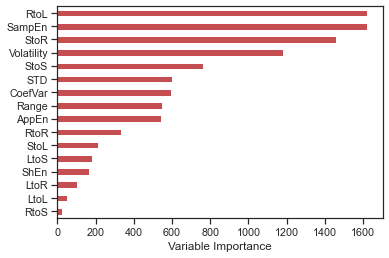

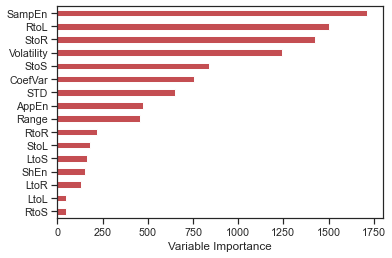

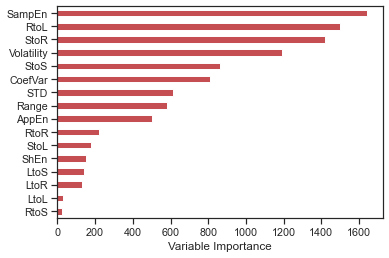

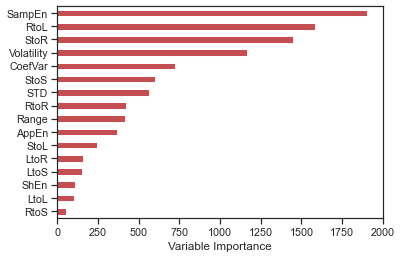

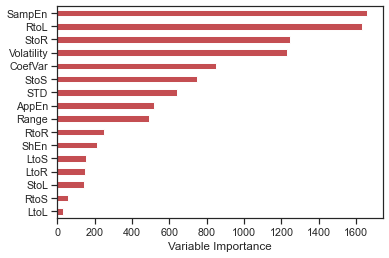

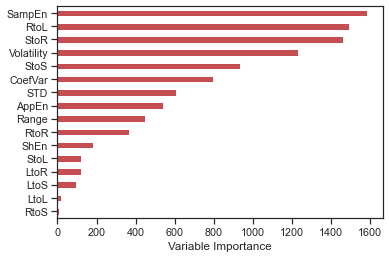

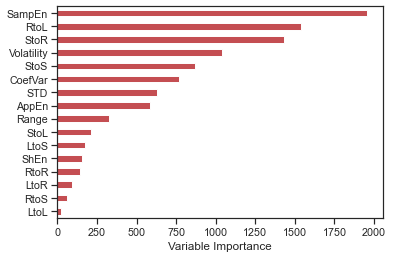

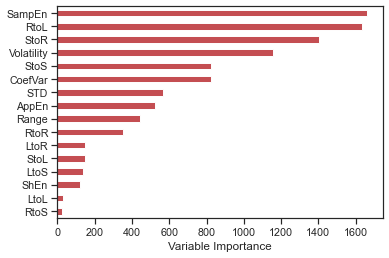

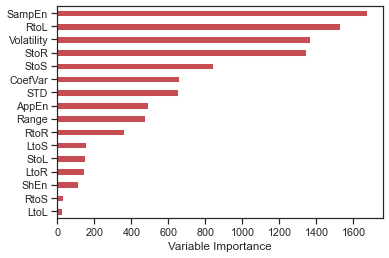

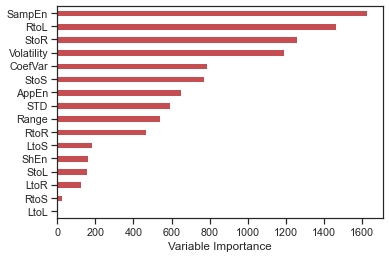

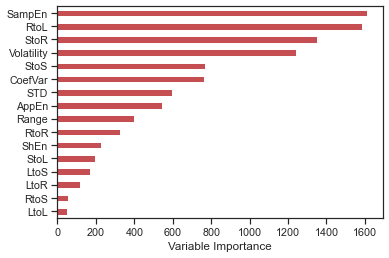

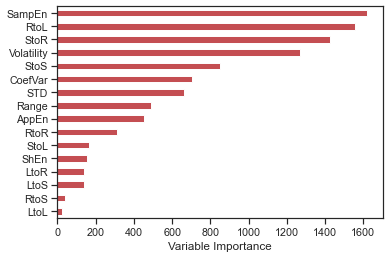

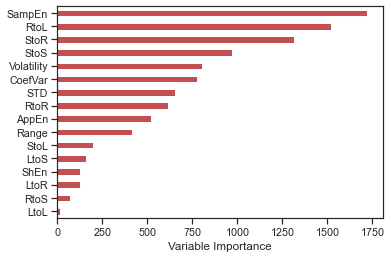

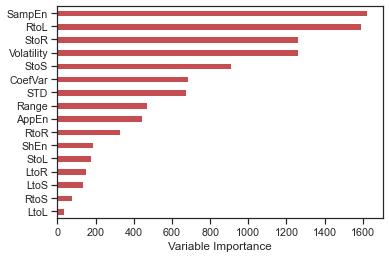

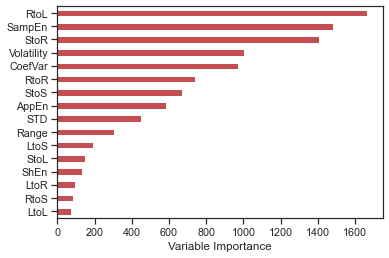

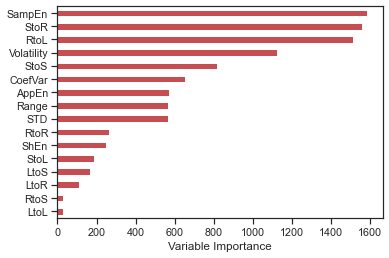

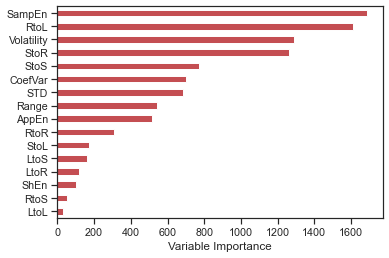

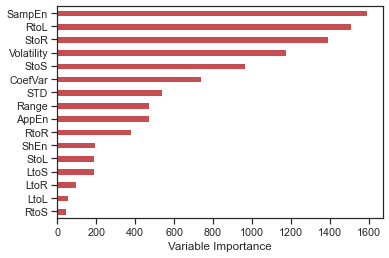

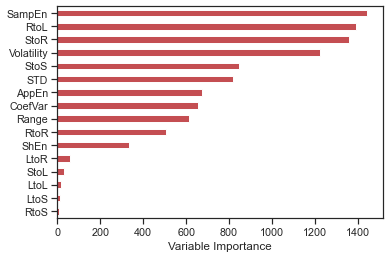

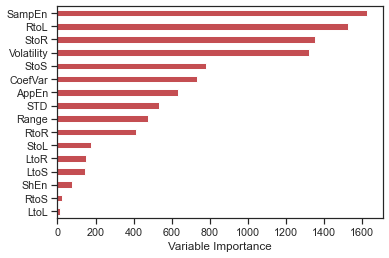

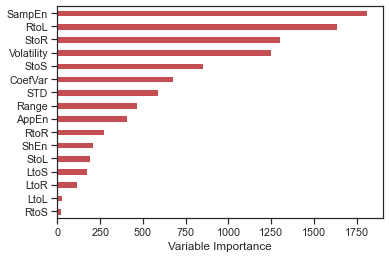

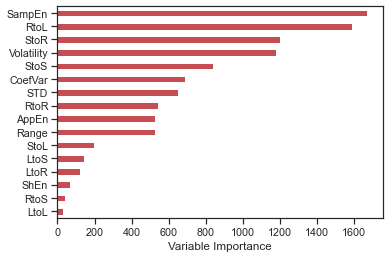

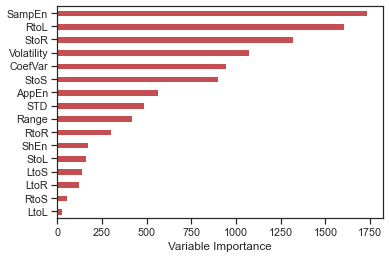

In [68]:
#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
 
x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values], df.loc[test_index,y_values]
    
    # Create CatBoost model
    model = CatBoostClassifier(iterations=100,
                           depth=4,
                           learning_rate=0.1,
                           loss_function='Logloss')
    # train the model
    model.fit(X_train, y_train, verbose=False)
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [59]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))

[[199  13]
 [  5 352]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       212
           1       0.96      0.99      0.98       357

    accuracy                           0.97       569
   macro avg       0.97      0.96      0.97       569
weighted avg       0.97      0.97      0.97       569



# Please neglect: The following are some codes to be developed

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html